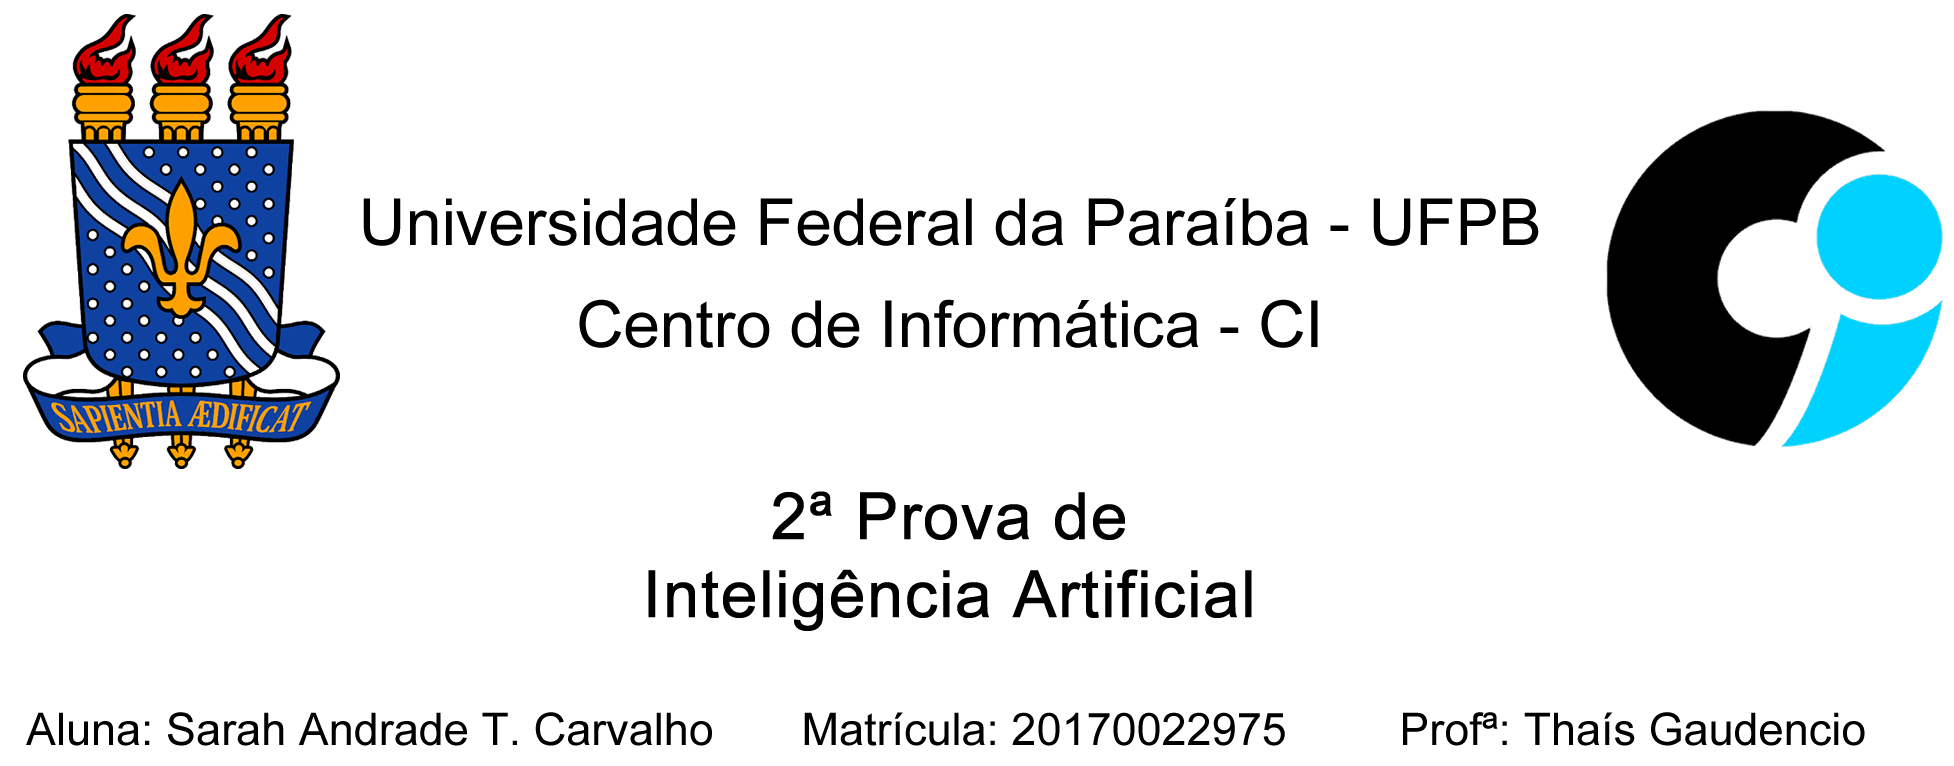

In [1]:
from IPython.display import Image
Image(filename='img/cabecalho.fw.png', width="700px")

# Questão 1

Acessar a base de dados HCV (https://archive.ics.uci.edu/ml/datasets/HCV+data#) e desenvolver **dois** algoritmos supervisionados, podendo ser Redes Neurais Artificiais, Árvore de Decisão ou outros de sua escolha, para classificação entre Doador ou Não Doador, que são positivos para Hepatite C, Fibrose ou Cirrose. 

Ambos modelos devem ser analisados pelas métricas: Acurácia, Especificidade, Sensibilidade e Matriz de Confusão e os resultados devem ser discutidos. Na base consta instâncias rotuladas como Possíveis Doadores (0s=suspect Blood Donor), que devem ser classificadas separadamente após a construção dos modelos, compare os resultados obtidos em cada método utilizado.

### Importação das bibliotecas

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt


In [3]:
from numpy.random import seed
import tensorflow
SEED=1624
tensorflow.random.set_seed(SEED)
print(seed)

<built-in method seed of numpy.random.mtrand.RandomState object at 0x000001E080249C40>


### Importação da base de dados

In [4]:
dataset = pd.read_csv('./database/data-Q1.csv', delimiter=',', index_col=0)


#### Codificação da variável independete, atributo "Sex"

In [5]:
dataset['Sex'] = dataset['Sex'].replace({'m': 0, 'f': 1})

In [6]:
dataset.head()

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
1,0=Blood Donor,32,0,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
2,0=Blood Donor,32,0,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
3,0=Blood Donor,32,0,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
4,0=Blood Donor,32,0,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
5,0=Blood Donor,32,0,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7


In [7]:
dataset["Category"].value_counts().sort_index()

0=Blood Donor             533
0s=suspect Blood Donor      7
1=Hepatitis                24
2=Fibrosis                 21
3=Cirrhosis                30
Name: Category, dtype: int64

## Pré-processamento

### Verificação de dados nulos

In [8]:
dataset.isnull().sum()

Category     0
Age          0
Sex          0
ALB          1
ALP         18
ALT          1
AST          0
BIL          0
CHE          0
CHOL        10
CREA         0
GGT          0
PROT         1
dtype: int64

### Exclusão dos dados nulos

In [9]:
dataset=dataset.dropna()

In [10]:
dataset.isnull().sum()

Category    0
Age         0
Sex         0
ALB         0
ALP         0
ALT         0
AST         0
BIL         0
CHE         0
CHOL        0
CREA        0
GGT         0
PROT        0
dtype: int64

### Divisão do dataset em dados de entrada (x) e de saída (y)

In [11]:
x = dataset.iloc[:, 1:].values


In [12]:
y = dataset.iloc[:, 0:1].values


In [13]:
#dimensão dos dados
x.shape

(589, 12)

### Codificação da Variável Dependente
→ Inicialmente todos os 4 rótulos do atributo _category_ serão codificados de string para números inteiros de 0-4, onde:
- 0: Blood Donor
- 1: Suspect Blood Donor
- 2: Hepatitis
- 3: Fibrosis
- 4: Cirrhosis


In [14]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [15]:
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

→ E em seguida, é realizada uma nova análise desses novos valores com o intuito de identificar quais deles são referentes ao casos: 
- Suspect Blood Donor (-1)
- Blood Donor (0)
- No Blood Donor (1)

Nesta etapa também é realizada a indexação das posições referentes as amostras dos casos suspeitos

In [16]:
i=0
suspect_index=[]
for i in range(0,len(y)):
    if(y[i]==1):
        y[i]=-1
        suspect_index.append(i)
    if(y[i]>=2):
        y[i]=1
print(y)

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

### Divisão do dataset entre casos supeitos e casos confiáveis
Com a utilização do array dos index das amostras suspeitas é realizada uma cópia dos atributos dessas amostras, as quais são armazenadas em x_suspect. E, de modo subsequente, todas os dados dos casos suspeitos são apagados do dataset x e y. 

In [17]:
print(suspect_index)

[526, 527, 528, 529, 530, 531, 532]


In [18]:
#Cópia dos dados x das amostras suspeitas para um novo array 
x_suspect=[0]*len(suspect_index)
for i in range (0, len(suspect_index)):
    x_suspect[i]=x[suspect_index[i]] #Salva os valores dos casos suspeitos em um array separado
x_suspect=np.array(x_suspect)#Converte a lista para numpy

print("X para os casos suspeitos:\n", x_suspect)

X para os casos suspeitos:
 [[ 47.     0.    22.5  124.    79.5   46.7    2.3    6.83   4.3  170.
  345.6   58.6 ]
 [ 48.     0.    24.9  116.9   49.2   24.3    4.9    3.44   5.25  29.
   83.    47.8 ]
 [ 49.     0.    21.6   42.2    9.5   10.6    2.4    3.75   3.01  64.
   38.9   44.8 ]
 [ 55.     0.    47.3  106.   208.8  130.6    0.8   14.8    8.08  76.
   71.6   78.3 ]
 [ 71.     0.    14.9   69.8   19.7   95.2    9.8   13.3    2.61   9.
    7.6   47.  ]
 [ 74.     0.    20.3   84.    22.8   43.     5.7    4.91   3.19  52.
  218.3   47.8 ]
 [ 59.     1.    19.3  208.2  325.3  146.6    6.9    5.33   4.72  32.
  295.6   53.1 ]]


In [19]:
#Retirada dos valores suspeitos do y
y = np.delete(y, suspect_index, axis=0)
print("Y dos doadores e não doadores:\n", y)

#Anexação do label -1 para os suspeitos
y_suspect=[-1]*len(suspect_index)
print("\nY para os casos suspeitos:\n", y_suspect)
y_suspect=np.array(y_suspect)

Y dos doadores e não doadores:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [20]:
# exclusão dos casos suspeitos do dataset confiável
x = np.delete(x, suspect_index, axis=0)
print(x)
print(len(x))

[[ 32.    0.   38.5 ... 106.   12.1  69. ]
 [ 32.    0.   38.5 ...  74.   15.6  76.5]
 [ 32.    0.   46.9 ...  86.   33.2  79.3]
 ...
 [ 62.    1.   32.  ...  55.7 650.9  68.5]
 [ 64.    1.   24.  ...  63.   35.9  71.3]
 [ 64.    1.   29.  ...  66.7  64.2  82. ]]
582


### Balanceamento dos dados

In [21]:
unique, counts = np.unique(y, return_counts=True)
a = dict(zip(unique, counts))
#amostras mínimas [1]
print(a[0]-a[1], a[0], a[1])
a = np.arange(0,a[0]-a[1]) #array de index p deletar do x, balanceamento
x = np.delete(x, a, axis=0)
y = np.delete(y, a, axis=0)

print(len(x))
print(len(y))

470 526 56
112
112


### Dividindo a base confiável em amostras de treinamento e teste

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)


### Feature Scaling

In [23]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
x_suspect = sc.transform(x_suspect)

## Algoritmo 1: Rede Neural Artificial, Perceptron com camada de entrada e saída

### Construção da Rede Neural

In [24]:
ann = tf.keras.models.Sequential()

### Adicionando neurônios e camadas

In [25]:
#Camada de entrada
ann.add(tf.keras.layers.Dense(units=12, activation='relu'))

In [26]:
#Camada oculta
ann.add(tf.keras.layers.Dense(units=2, activation='relu'))

In [27]:
#Camada de saída
ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

### Treinando a Rede

In [28]:
ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [29]:
history = ann.fit(X_train, y_train, validation_split=0.2, epochs=200, batch_size=10, verbose=0)

### Predição dos resultados e análise do modelo

In [30]:
y_pred = ann.predict(X_test)
y_pred = (y_pred > 0.7)


#### Matriz de Confusão

In [31]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[11  0]
 [ 0 12]]


#### Sensibilidade

In [32]:
print (cm[1][1] / (cm[0][1]+cm[1][1]))

1.0


#### Especificidade

In [33]:
print (cm[0][0] / (cm[0][0]+cm[1][0]))

1.0


#### Acurácia

In [34]:
accuracy_score(y_test, y_pred)

1.0

In [35]:
from sklearn import metrics
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        12

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23



### Análise Gráfica da acurácia e do loss do modelo

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


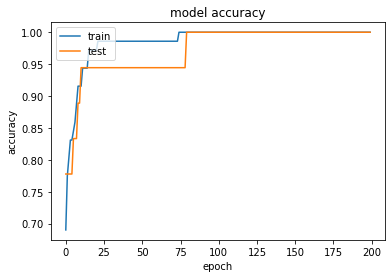

In [36]:
# summarize history for accuracy
print(history.history.keys())  
plt.figure(1)  

# summarize history for accuracy  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left') 

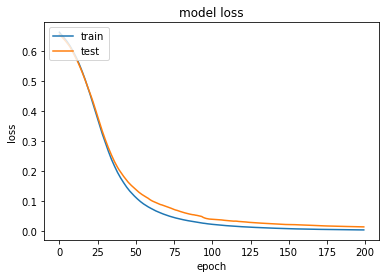

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Classificação dos casos suspeitos

In [38]:
pd.DataFrame.from_records(x_suspect)

,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.579242,-1.402379,-2.816610,1.170617,4.730952,-0.215312,-0.554946,-0.293807,-0.754010,1.367418,2.705404,-1.990314
1,-0.486019,-1.402379,-2.418760,1.020580,2.380555,-0.567471,-0.464805,-1.520212,-0.032675,-0.765152,0.163286,-3.713198
2,-0.392795,-1.402379,-2.965803,-0.557979,-0.699010,-0.782854,-0.551479,-1.408063,-1.733505,-0.235791,-0.263627,-4.191777
3,0.166545,-1.402379,1.294501,0.790241,14.760868,1.103711,-0.606950,2.589511,2.116141,-0.054296,0.052928,1.152353
4,1.658120,-1.402379,-4.076466,0.025263,0.092213,0.547175,-0.294925,2.046854,-2.037225,-1.067645,-0.566629,-3.840819
5,1.937790,-1.402379,-3.181305,0.325338,0.332683,-0.273481,-0.437070,-0.988408,-1.596832,-0.417286,1.473067,-3.713198
6,0.539439,0.713074,-3.347076,2.949930,23.797876,1.355253,-0.395466,-0.836464,-0.435104,-0.719779,2.221375,-2.867709


In [39]:
y_pred_suspect = ann.predict(np.array(x_suspect))
y_pred_suspect = (y_pred_suspect>0.7)
print(y_pred_suspect)


[[False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]]


In [40]:
print("Legenda:\n False = Doador de sangue,  True= Não-doador")

Legenda:
 False = Doador de sangue,  True= Não-doador


## Algoritmo 2: Árvore de decisão

In [41]:
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.model_selection import train_test_split

In [42]:
clf = DecisionTreeClassifier(random_state = SEED)

### Treinamento da árvore

In [43]:
clf = clf.fit(X_train,y_train)

### Predição do resultado

In [44]:
arvore_prediction = clf.predict(X_test)
arvore_prediction

array([0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       1])

### Análise do resultado

#### Acurácia

In [45]:
print(metrics.classification_report(y_test,arvore_prediction))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87        11
           1       0.91      0.83      0.87        12

    accuracy                           0.87        23
   macro avg       0.87      0.87      0.87        23
weighted avg       0.87      0.87      0.87        23



#### Matriz de confusão

In [46]:
cm = confusion_matrix(y_test, arvore_prediction)
cm

array([[10,  1],
       [ 2, 10]], dtype=int64)

#### Sensibilidade

In [47]:
print (cm[1][1] / (cm[0][1]+cm[1][1]))

0.9090909090909091



#### Especificidade


In [48]:
print (cm[0][0] / (cm[0][0]+cm[1][0]))

0.8333333333333334


### Classificação dos casos suspeitos com árvore

In [49]:
arvore_pred_suspect = clf.predict(x_suspect)
arvore_pred_suspect = (arvore_pred_suspect>0.7)
arvore_pred_suspect

array([ True, False, False,  True, False, False, False])

In [50]:
print("Legenda:\n False = Doador de sangue,  True= Não-doador")

Legenda:
 False = Doador de sangue,  True= Não-doador


## Comparação entre resultados da ann e da árvore de decisão

In [51]:
print(y_pred_suspect.T)
print(arvore_pred_suspect)

[[False False False False False False False]]
[ True False False  True False False False]


In [52]:
print("Legenda:\n False = Doador de sangue,  True= Não-doador")

Legenda:
 False = Doador de sangue,  True= Não-doador
